In [1]:
!nvidia-smi

Tue Apr  1 21:40:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   61C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install ninja --quiet

from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 6.6 MB/s eta 0:00:00
Mounted at /content/drive


In [9]:
from pathlib import Path
import torch
from torchvision.io import read_image, write_png
from torch.utils.cpp_extension import load_inline
import os
import shutil

build_directory = './cuda_build'
if os.path.exists(build_directory):
    shutil.rmtree(build_directory)
if not os.path.exists(build_directory):
    os.makedirs(build_directory)

def compile_extension():
    cuda_source = Path("/content/drive/MyDrive/Cuda_Learning/kernels/blur.cu").read_text()
    cpp_source = "torch::Tensor blur_image(torch::Tensor image);"

    # Load the CUDA kernel as a PyTorch extension
    blur_extension = load_inline(
        name="blurv4",
        cpp_sources=cpp_source,
        cuda_sources=cuda_source,
        functions=["blur_image"],
        with_cuda=True,
        extra_cuda_cflags=["-O2"],
        verbose=True,
        build_directory=build_directory,
    )
    return blur_extension


def _main():
    ext = compile_extension()

    x = read_image("/content/drive/MyDrive/Cuda_Learning/imgs/test.png").permute(1, 2, 0).cuda()
    print("mean:", x.float().mean())
    print("Input image:", x.shape, x.dtype)

    assert x.dtype == torch.uint8

    y = ext.blur_image(x)

    print("Output image:", y.shape, y.dtype)
    print("mean", y.float().mean())
    write_png(y.permute(2, 0, 1).cpu(), "/content/drive/MyDrive/Cuda_Learning/imgs_out/output.png")

_main()

Detected CUDA files, patching ldflags
Emitting ninja build file ./cuda_build/build.ninja...
/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module blurv4...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module blurv4...


mean: tensor(117.7304, device='cuda:0')
Input image: torch.Size([1024, 1536, 3]) torch.uint8
Output image: torch.Size([1024, 1536, 3]) torch.uint8
mean tensor(117.2616, device='cuda:0')


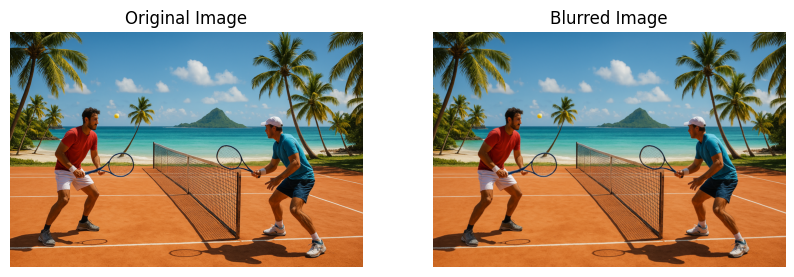

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Assuming your image paths are stored in variables
original_image_path = '/content/drive/MyDrive/Cuda_Learning/imgs/test.png'
blurred_image_path = '/content/drive/MyDrive/Cuda_Learning/imgs_out/output.png'

# Load the images
original_image = mpimg.imread(original_image_path)
blurred_image = mpimg.imread(blurred_image_path)

# Create a figure and axes
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the original image
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[0].axis('off')  # Turn off axis ticks and labels

# Display the blurred image
axes[1].imshow(blurred_image)
axes[1].set_title('Blurred Image')
axes[1].axis('off')  # Turn off axis ticks and labels

# Show the plot
plt.show()